# Calculation of Total Energy

This is the focus in studyingthe calculation of total energy (kWh - kiowatt Watt per hour) usage in NILMTK.   The ***totalenery.py*** file contains the **TotalEnergy(Node)** class and other functions.  Below two functions to need to take note

- timedelta64_to_secs(timedelta)
- _energy_for_power_series(series, max_sample_period)

In summary, it first convert data in **second** (6 Sampling Rate) to Joule unit.
**"joules = watts x seconds"**.  Then, it sum up the values, then it will be total of joules for the period of time.   Next step, the total value divides by **"JOULES_PER_KWH = 3600000"**.   The return value is represent as kWh unit.

- 1 [Watt] = 1 [J/s]
- 1 kWh = 1000Wh = [1000[J]/1[s]]* 3600[s] = 3,600,000[J]

# Initialization

In [4]:
import dateutil
import gc
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime

import nilmtk as ntk
import utility.tools as ut

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15, 10]

RAW_FILENAME = "../../../ukdale/ukdale.h5"

START_TS ='2014-12-07 00:00:00'
END_TS='2014-12-07 23:59:59'


HOUSE_NUMBER = 1

# 1 kWh, 3600000 J
JOULES_PER_KWH = 3600000

# Create Objects and Set Window Timeframe

Dataset -> MeterGroup -> Dataframe

In [5]:
# Create Dataset object for UK-DALE
ukdale_ds = ntk.DataSet(RAW_FILENAME)

# Set the duration window from START_TS to END_TS
ukdale_ds.set_window(start=START_TS,end=END_TS)

# Create object for house_data and
# using global variable "HOUSE_NUMBER"
#
house_data = ukdale_ds.buildings[HOUSE_NUMBER].elec

# Create a 'mains' variable
mains = house_data.mains()

mains.total_energy()

active       9.778906
apparent    11.003908
dtype: float64

# Explore **Mains**  Dataset:  2014-12-07 

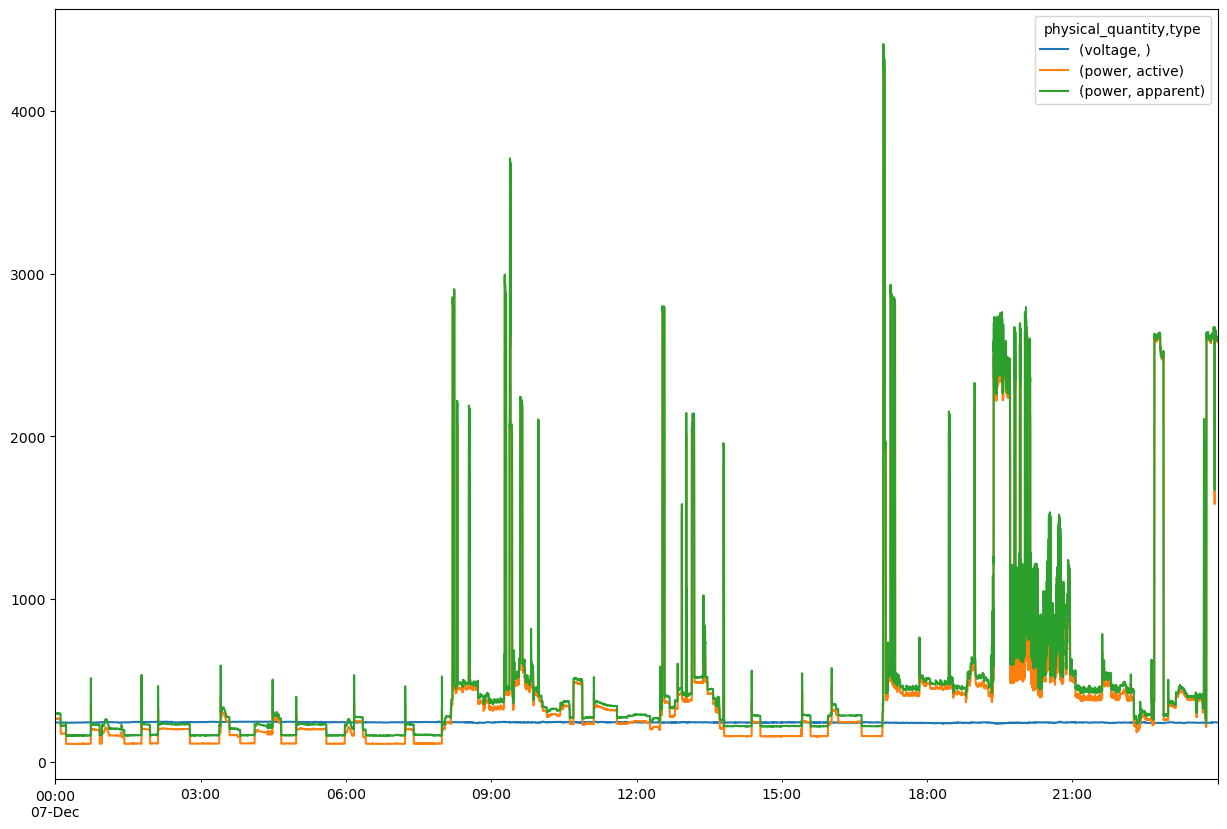

In [6]:
mains_df = next(mains.load(sample_period=6))

mains_df.plot()

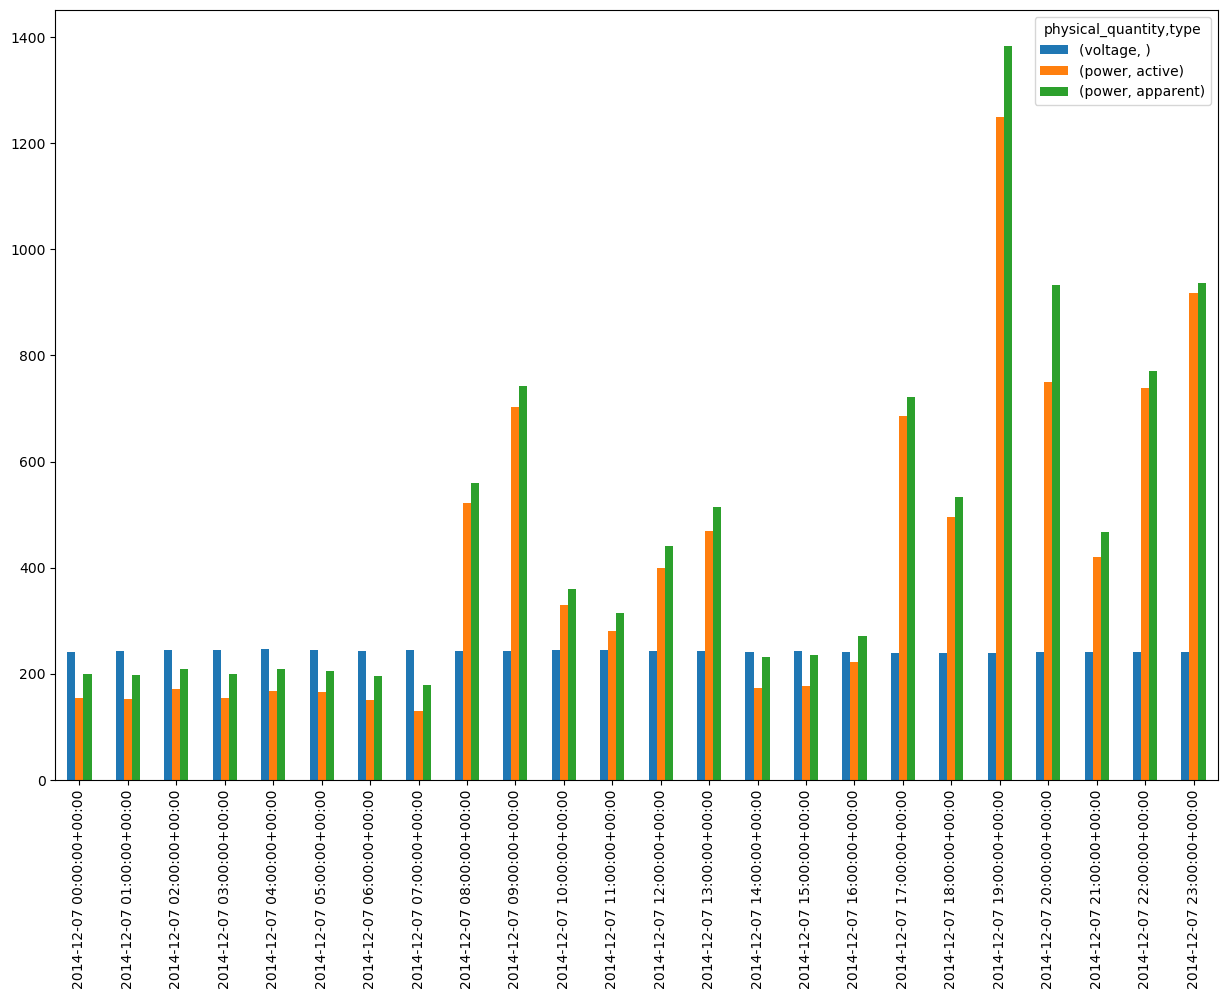

In [7]:
mains_in_hour_df = mains_df["2014-12-07"].resample('60min').mean()

mains_in_hour_df.plot(kind="bar")

In [8]:
mains_in_hour_df.mean() * 10

physical_quantity  type    
voltage                        2423.642334
power              active      4075.002441
                   apparent    4585.483887
dtype: float32

# Calculation of kWh in Joules units with NILMTK

**Joule** is a derived units of energy in the International System of Units.  It is equal to the amount of work done when force of 1 newton displaces a mass through distance of 1 metre in the diection of the force applied. [wiki](https://en.wikipedia.org/wiki/Joule)

joules = watts x seconds

JOULES_PER_KWH = 3600000 

In [9]:
def timedelta64_to_secs(timedelta):
    """Convert `timedelta` to seconds.

    Parameters
    ----------
    timedelta : np.timedelta64

    Returns
    -------
    float : seconds
    """
    if len(timedelta) == 0:
        return np.array([])
    else:
        return timedelta / np.timedelta64(1, 's')

In [10]:
def _energy_for_power_series(series, max_sample_period):
    """
    Parameters
    ----------
    series : pd.Series
    max_sample_period : float or int

    Returns
    -------
    energy : float
        kWh
    """
    series = series.dropna()
    timedelta = np.diff(series.index.values)
    print("Data Type of timedelta - {}".format(type(timedelta)))
    timedelta_secs = timedelta64_to_secs(timedelta)
    del timedelta
    gc.collect()
    timedelta_secs = timedelta_secs.clip(max=max_sample_period)
    joules = (timedelta_secs * series.values[:-1]).sum()
    kwh = joules / JOULES_PER_KWH
    return kwh

In [11]:
sr_mains_apparent = mains_df[('power', 'apparent')]

In [12]:
mains_aday_energy_custom = _energy_for_power_series(sr_mains_apparent, 6)

mains_aday_energy_api = mains.total_energy()

print("\nTotal Energy Usage (apparent) for a day kWh at 2014-12-07")
print("Custom          - {:.3f} ".format(mains_aday_energy_custom))
print("From NILMTK API - {:.3f} ".format(mains_aday_energy_api['apparent']))

Data Type of timedelta - <class 'numpy.ndarray'>

Total Energy Usage (apparent) for a day kWh at 2014-12-07
Custom          - 11.001 
From NILMTK API - 11.004 


## Function Break Down Analysis

In [13]:
# Raw mains data for a day
sr_raw = mains_df[('power', 'apparent')]

# There is no null, anywhere, drop those null value
sr = sr_raw.dropna()

sr.count

<bound method Series.count of 2014-12-07 00:00:00+00:00     298.501648
2014-12-07 00:00:06+00:00     297.976685
2014-12-07 00:00:12+00:00     297.378326
2014-12-07 00:00:18+00:00     297.746674
2014-12-07 00:00:24+00:00     297.863342
                                ...     
2014-12-07 23:59:30+00:00    2589.909912
2014-12-07 23:59:36+00:00    2596.818359
2014-12-07 23:59:42+00:00    2596.135010
2014-12-07 23:59:48+00:00    2597.955078
2014-12-07 23:59:54+00:00    2591.912109
Freq: 6S, Name: (power, apparent), Length: 14400, dtype: float32>

In [14]:
timedelta = np.diff(sr.index.values)

print(type(timedelta))
print(len(timedelta))

<class 'numpy.ndarray'>
14399


In [15]:
timedelta

array([6000000000, 6000000000, 6000000000, ..., 6000000000, 6000000000,
       6000000000], dtype='timedelta64[ns]')

In [16]:
timedelta_secs = timedelta64_to_secs(timedelta)

print(type(timedelta_secs))
print(len(timedelta_secs))
timedelta_secs

<class 'numpy.ndarray'>
14399


array([6., 6., 6., ..., 6., 6., 6.])

In [17]:
timedelta_secs = timedelta_secs.clip(max=6)

print(type(timedelta_secs))
print(len(timedelta_secs))
timedelta_secs

<class 'numpy.ndarray'>
14399


array([6., 6., 6., ..., 6., 6., 6.])

In [18]:
joules = (timedelta_secs * sr.values[:-1]).sum()

In [19]:
print(type(joules))
print(len(sr.values[:-1]))

<class 'numpy.float64'>
14399


In [20]:
joules

39603024.72015381

In [21]:
arr1 = np.array([1, 2, 3, 4, 5])
arr2 = np.array([10, 20, 30, 40, 50])
tot = (arr1 * arr2).sum()
tot

550

# Workout & Findings

After the completion this notebook, prepare a simple presentation slide to express your summary and new discovery information from here.

Suggestion: 
- May design a loop to get kWh for daily of mains
- May design a loop to get appliances